In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

import json

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [4]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


# Chain of thought

## OpenAI / GPT

In [5]:
openai_client

### Cot

In [6]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [7]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in irony_subset.iterrows():
    text = row['text']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( # .chat.completions.create(
            model="gpt-4o", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { # Return only 0 or 1 without additional text. Use 0 for negative and 1 for positive Sentiments.
                "role": "system", 
                "content": """You determine whether a text contains ironic or sarcastic elements. 
                    Return 0 for No and 1 for Yes."""
                },
                {
                "role": "user",
                 "content": (f"""
                    Q: Does the following text contain ironic or sarcastic elements?  Text: "That moment when you have so much stuff to do but you open @tumblr … #productivity #tumblr"
                    A: The sentence “That moment when you have so much stuff to do but you open @tumblr … #productivity #tumblr” can be classified as ironic for several reasons.
                    First, the speaker mentions having “so much stuff to do,” which implies a sense of urgency or the need to be productive. This would normally suggest that they should focus on their tasks.
                    However, instead of working on these tasks, the speaker states that they opened Tumblr, a platform often associated with leisure, distraction, and procrastination rather than productivity. The speaker juxtaposes the idea of needing to be productive with the act of wasting time on Tumblr, which creates a contradiction between expectations and reality.
                    Moreover, the use of hashtags like “#productivity” adds to the irony. By labeling their unproductive behavior as “productivity,” the speaker knowingly highlights the absurdity of their situation. The hashtags suggest that the speaker is aware of the contradiction, further reinforcing the ironic tone.
                    In summary, the irony comes from the mismatch between the expectation of being productive and the reality of procrastinating on Tumblr, with the hashtags emphasizing this contrast in a humorous way.
                 Does the following text contain ironic or sarcastic elements? 
                 Text: {text}. """)
                }
            ],
            temperature = 0.2,
            response_format=CoT
        )
        response_content = response.choices[0].message.parsed #response.choices[0].message.content
        result_step = response_content.steps
        final_answer = response_content.final_answer
        print(response_content)
        # print(index, " ", "Label: ",final_answer )        
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df.loc[row_counter] = [index, text, result_step, final_answer] # [index, text, steps, response_content]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")





steps=[Step(explanation="The text mentions a 'Sweet United Nations video' and then adds 'Just in time for Christmas.' The hashtags '#imagine' and '#NoReligion' are included, along with a link. The phrase 'Just in time for Christmas' could be seen as sarcastic, especially if the video content is not actually related to Christmas or if it contrasts with the typical themes associated with Christmas, such as religion. The hashtag '#NoReligion' further suggests a possible contrast or critique, as Christmas is traditionally a religious holiday. This juxtaposition can imply sarcasm, as the speaker might be highlighting a perceived inconsistency or irony in the timing or content of the video.", output='1')] final_answer='1'
steps=[Step(explanation="The text mentions that there are rumors about talking to Erv's agent and the Angels asking about Ed Escobar. The phrase 'that's hardly nothing' suggests that these actions are significant or noteworthy, contradicting the literal meaning of 'hardly n

In [8]:
results_gpt_df

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"[explanation=""The text mentions a 'Sweet Unite...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[explanation=""The text mentions that there are...",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"[explanation=""The text 'Hey there! Nice to see...",1
3,3,3 episodes left I'm dying over here,"[explanation='The phrase ""3 episodes left I\'m...",1
4,4,I can't breathe! was chosen as the most notabl...,"[explanation='The phrase ""I can\'t breathe!"" i...",0
...,...,...,...,...
996,996,It was a greaaaat night! :white_smiling_face:️...,"[explanation=""The text 'It was a greaaaat nigh...",0
997,997,@StephHammy I wonder if they have that in an a...,"[explanation='The text ""@StephHammy I wonder i...",0
998,998,Queens Of The Stone Age no Rock In Rio http://...,[explanation='The text simply states that Quee...,0
999,999,@jordyn_eaton wants me to get hit by a bus so ...,"[explanation=""The text mentions that someone w...",1


In [9]:
sicherung = results_gpt_df

In [10]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_final = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

#results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final_ver = results_gpt_df_final[results_gpt_df_final['generated_label'].isin(['0', '1',0, 1])]

# als int formatieren
results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_89291/2120051496.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)


In [11]:
results_gpt_df_final_ver

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"[explanation=""The text mentions a 'Sweet Unite...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[explanation=""The text mentions that there are...",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"[explanation=""The text 'Hey there! Nice to see...",1
3,3,3 episodes left I'm dying over here,"[explanation='The phrase ""3 episodes left I\'m...",1
4,4,I can't breathe! was chosen as the most notabl...,"[explanation='The phrase ""I can\'t breathe!"" i...",0
...,...,...,...,...
996,996,It was a greaaaat night! :white_smiling_face:️...,"[explanation=""The text 'It was a greaaaat nigh...",0
997,997,@StephHammy I wonder if they have that in an a...,"[explanation='The text ""@StephHammy I wonder i...",0
998,998,Queens Of The Stone Age no Rock In Rio http://...,[explanation='The text simply states that Quee...,0
999,999,@jordyn_eaton wants me to get hit by a bus so ...,"[explanation=""The text mentions that someone w...",1


In [12]:

# CSV abspeichern 
results_gpt_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/MAST_CoT_GPT4o.csv')


### Evaluation

In [13]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(irony_subset, results_gpt_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['Label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.71
Precision: 0.66
Recall: 0.86
F1-Score: 0.75
Confusion Matrix:
[[269 217]
 [ 68 430]]


In [17]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.80      0.55      0.65       486
           1       0.66      0.86      0.75       498

    accuracy                           0.71       984
   macro avg       0.73      0.71      0.70       984
weighted avg       0.73      0.71      0.70       984



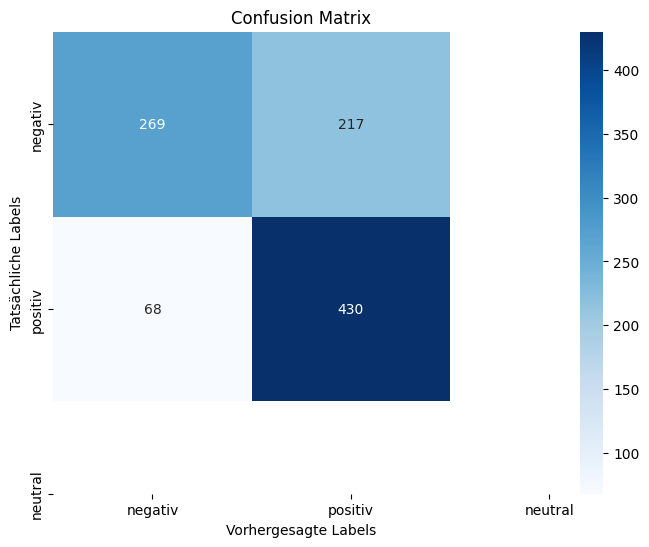

In [14]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

In [18]:
genai_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash-001',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### Irony

In [12]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


In [13]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""You determine whether a text contains ironic or sarcastic elements. 
                            Return 0 for No and 1 for Yes. Use this JSON Schema: Result = {'steps':str, 'final_answer': str} 
                 """,
    generation_config={"response_mime_type": "application/json"})





# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in irony_subset.iterrows():
    text = row['text']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""
                    Q: Does the following text contain ironic or sarcastic elements?  Text: "That moment when you have so much stuff to do but you open @tumblr … #productivity #tumblr"
                    A: The sentence “That moment when you have so much stuff to do but you open @tumblr … #productivity #tumblr” can be classified as ironic for several reasons.
                    First, the speaker mentions having “so much stuff to do,” which implies a sense of urgency or the need to be productive. This would normally suggest that they should focus on their tasks.
                    However, instead of working on these tasks, the speaker states that they opened Tumblr, a platform often associated with leisure, distraction, and procrastination rather than productivity. The speaker juxtaposes the idea of needing to be productive with the act of wasting time on Tumblr, which creates a contradiction between expectations and reality.
                    Moreover, the use of hashtags like “#productivity” adds to the irony. By labeling their unproductive behavior as “productivity,” the speaker knowingly highlights the absurdity of their situation. The hashtags suggest that the speaker is aware of the contradiction, further reinforcing the ironic tone.
                    In summary, the irony comes from the mismatch between the expectation of being productive and the reality of procrastinating on Tumblr, with the hashtags emphasizing this contrast in a humorous way.
                 Does the following text contain ironic or sarcastic elements? 
                 Text: {text}.""")
        llm_output = response.text
        # print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, steps, final_result]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   output:   1
1   output:   1
2   output:   1
3   output:   1
4   output:   1
5   output:   1
6   output:   1
7   output:   1
8   output:   1
9   output:   0
10   output:   1
11   output:   1
12   output:   1
13   output:   0
14   output:   1
15   output:   1
16   output:   1
17   output:   1
18   output:   1
19   output:   1
20   output:   1
21   output:   1
22   output:   0
23   output:   0
24   output:   1
25   output:   Yes
26   output:   1
27   output:   Yes
28   output:   1
29   output:   1
30   output:   1
31   output:   1
32   output:   0
33   output:   1
34   output:   1
35   output:   0
36   output:   1
37   output:   1
38   output:   1
39   output:   1
40   output:   1
41   output:   1
42   output:   1
43   output:   1
44   output:   1
45   output:   0
46   output:   1
47   output:   0
48   output:   1
49   output:   0
50   output:   1
51   output:   1
52   output:   1
53   output:   0
54   output:   1
55   output:   1
56   output:   1
57   output:   0
58   output:   1
59 

In [14]:
results_gemini_df

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"The text mentions a ""Sweet United Nations vide...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"The text ""@mrdahl87 We are rumored to have tal...",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"The sentence ""Hey there! Nice to see you Minne...",1
3,3,3 episodes left I'm dying over here,"The phrase ""3 episodes left I'm dying over her...",1
4,4,I can't breathe! was chosen as the most notabl...,The text 'I can't breathe! was chosen as the m...,1
...,...,...,...,...
991,996,It was a greaaaat night! :white_smiling_face:️...,The text uses excessive emojis and exclamation...,1
992,997,@StephHammy I wonder if they have that in an a...,"The text ""@StephHammy I wonder if they have th...",0
993,998,Queens Of The Stone Age no Rock In Rio http://...,"The text ""Queens Of The Stone Age no Rock In R...",0
994,999,@jordyn_eaton wants me to get hit by a bus so ...,"The sentence ""@jordyn_eaton wants me to get hi...",1


In [15]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({'no': 0, 'yes': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1,'0','1'])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




In [16]:
results_gemini_df_final_ver

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"The text mentions a ""Sweet United Nations vide...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"The text ""@mrdahl87 We are rumored to have tal...",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"The sentence ""Hey there! Nice to see you Minne...",1
3,3,3 episodes left I'm dying over here,"The phrase ""3 episodes left I'm dying over her...",1
4,4,I can't breathe! was chosen as the most notabl...,The text 'I can't breathe! was chosen as the m...,1
...,...,...,...,...
991,996,It was a greaaaat night! :white_smiling_face:️...,The text uses excessive emojis and exclamation...,1
992,997,@StephHammy I wonder if they have that in an a...,"The text ""@StephHammy I wonder if they have th...",0
993,998,Queens Of The Stone Age no Rock In Rio http://...,"The text ""Queens Of The Stone Age no Rock In R...",0
994,999,@jordyn_eaton wants me to get hit by a bus so ...,"The sentence ""@jordyn_eaton wants me to get hi...",1


In [18]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/MAST_CoT_GEMINI.csv', encoding='utf-8-sig')


#### Evaluation

In [19]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(irony_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['Label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.63
Precision: 0.59
Recall: 0.88
F1-Score: 0.71
Confusion Matrix:
[[180 308]
 [ 60 448]]


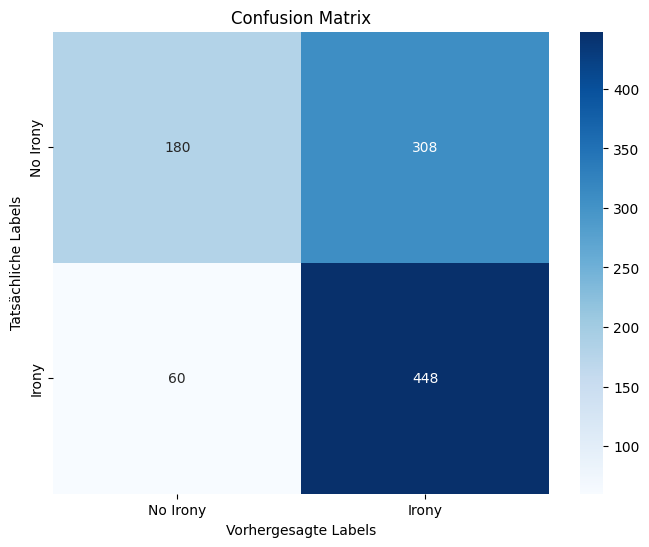

In [20]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['No Irony', 'Irony']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()